# 02 – Unhedged Daily Reversal Strategy

This notebook mirrors the original unhedged reversal strategy:

- Load the daily **excess** returns panel from `data_processing`.
- Build an event-driven reversal signal:
  - On day *t*, if |return_t| > threshold, signal_t = −return_t; else no trade.
- Use next-day returns as forward returns.
- Run a cross-sectional long/short backtest using `backtest.long_short_backtest`.
- Compute rank-IC and performance summary with `performance` and visualize with `plotting`.

In [9]:
from pathlib import Path

import pandas as pd

from stat_arb import config, data_pipeline, strategies, backtest, performance, plotting

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

paths_cfg = config.get_paths_config()
unhedged_cfg = config.get_strategy_config("unhedged_reversal")

data_cfg = paths_cfg.get("data", {})
processed_dir = Path(data_cfg.get("processed_dir", "data/processed"))
panel_name = unhedged_cfg.get(
    "panel_name",
    data_cfg.get("panel_name", "daily_excess_returns.parquet"),
)
panel_path = processed_dir / panel_name

panel_path

PosixPath('data/processed/daily_excess_returns.parquet')

### Load returns panel

In [10]:
returns = pd.read_parquet(panel_path)
returns = returns.sort_index()
returns.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2016-01-04 to 2025-12-09
Columns: 1303 entries, A to ZTS
dtypes: float64(1303)
memory usage: 24.9 MB


### Build reverse signal

In [11]:
threshold = float(unhedged_cfg.get("zscore_threshold", 0.02))
print(f"Reversal threshhold (absolute daily returns): {threshold:.4f}")

reversal_signals = strategies.compute_reversal_signal(
    returns=returns,
    threshold=threshold,
)

reversal_signals.describe().T.head(20)

Reversal threshhold (absolute daily returns): 0.0200


,count,mean,std,min,25%,50%,75%,max
A,482.0,0.000158,0.034501,-0.098382,-0.025924,-0.020135,0.027832,0.110209
AA,1181.0,-0.001943,0.048906,-0.282175,-0.036492,-0.020435,0.033285,0.210729
AAL,950.0,0.000288,0.051930,-0.410964,-0.033107,0.020918,0.034895,0.252258
AAP,696.0,0.000607,0.049765,-0.570260,-0.029824,-0.020136,0.030074,0.350556
AAPL,485.0,-0.001144,0.037136,-0.153125,-0.028475,-0.020395,0.028339,0.128658
...,...,...,...,...,...,...,...,...
ACIW,626.0,-0.001191,0.040883,-0.157251,-0.028733,-0.020126,0.029384,0.186189
ACM,509.0,-0.001859,0.038768,-0.146786,-0.028111,-0.020617,0.026589,0.168874
ACN,363.0,0.002243,0.036663,-0.128562,-0.026802,0.021155,0.029745,0.093279
AD,636.0,-0.001255,0.061120,-0.928938,-0.028865,0.020102,0.031060,0.224316


### Forward returns alignment

In [12]:
fwd_returns = returns.shift(-1)

# Drop last row with NaN forward returns
reversal_signals = reversal_signals.iloc[:-1]
fwd_returns = fwd_returns.iloc[:-1]

reversal_signals.shape, fwd_returns.shape

((2498, 1303), (2498, 1303))

### Backtest config and run

In [13]:
cfg = backtest.BacktestConfig(
    top_frac=float(unhedged_cfg.get("top_frac", 0.1)),
    bottom_frac=float(unhedged_cfg.get("bottom_frac", 0.1)),
    cost_bps=float(unhedged_cfg.get("cost_bps", 0.0)),
    min_names=int(unhedged_cfg.get("min_names", 10))
)

In [14]:
%%time

portfolio_returns, weights = backtest.long_short_backtest(
    fwd_returns=fwd_returns,
    signal=reversal_signals,
    cfg=cfg,
)

CPU times: user 2.81 s, sys: 74.4 ms, total: 2.89 s
Wall time: 2.96 s


### Rank IC and performance summary

In [ ]:
ic_series = performance.rank_ic_by_date(
    signal = reversal_signals,
    fwd_returns = fwd_returns
)

summary = performance.summarize_portfolio_performance(
    portfolio_returns=portfolio_returns,
    ic_series=ic_series,
    periods_per_year=252,
)   

#Display summary in df format
summary_table = performance.build_summary_table(
    {"Unhedged Reversal": summary}
)

summary_table

,Mean IC,IC Hit Rate,Cumulative Return,Sharpe,Max Drawdown
Strategy,,,,,
Unhedged Reversal,0.01095,0.527622,-0.98239,-1.007723,-0.996175


### Plots: equity curves and IC

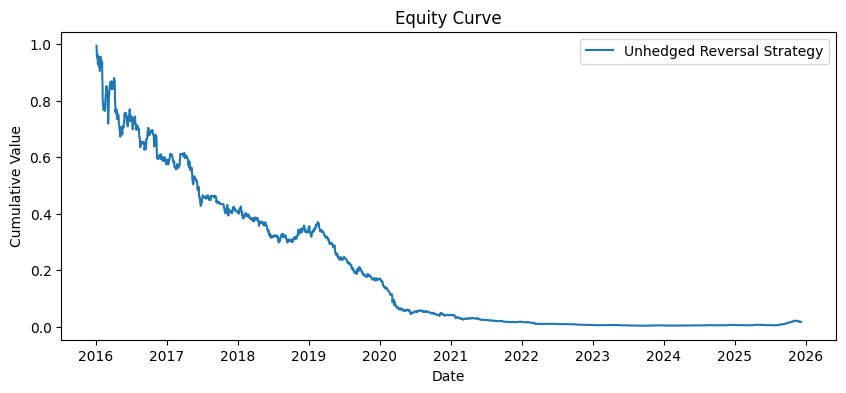

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4))
plotting.plot_equity_curve(portfolio_returns, ax=ax, label="Unhedged Reversal Strategy")
plt.show()

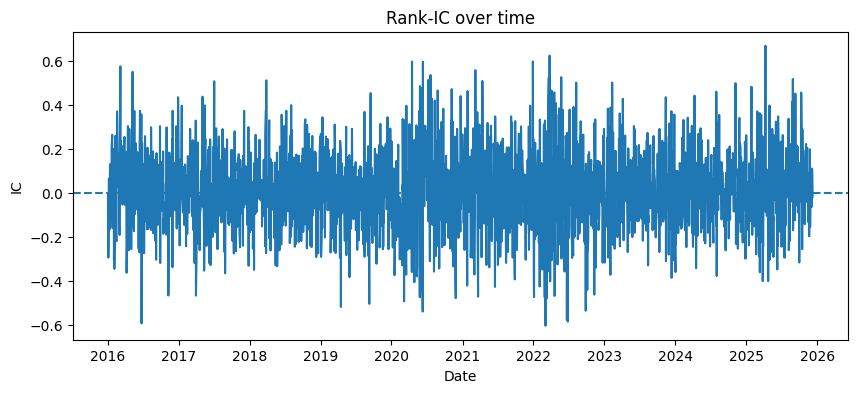

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4))
plotting.plot_ic_timeseries(ic_series, ax=ax)
plt.show()

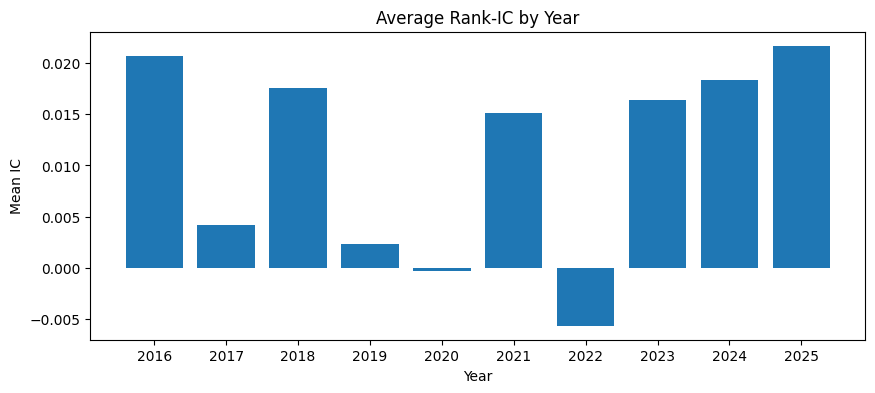

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4))
plotting.plot_ic_by_year(ic_series, ax=ax)
plt.show()

In [ ]:
## EOF

### Save .par files for 04 use

In [30]:
from pathlib import Path
import pandas as pd
from stat_arb import config

paths_cfg = config.get_paths_config()
data_cfg = paths_cfg.get("data", {})
processed_dir = Path(data_cfg.get("processed_dir", "data/processed"))

out_dir = processed_dir / "unhedged_reversal"
out_dir.mkdir(parents=True, exist_ok=True)

print("Saving unhedged reversal outputs to:", out_dir)

# portfolio_returns is a Series → convert to DataFrame
pd.DataFrame({"portfolio_ret": portfolio_returns}).to_parquet(
    out_dir / "portfolio_returns.parquet", engine="fastparquet"
)

# ic_series is a Series → convert to DataFrame with a column name
ic_series.to_frame("rank_ic").to_parquet(out_dir / "rank_ic.parquet", engine="fastparquet")

# weights is already a DataFrame
weights.to_parquet(out_dir / "weights.parquet", engine="fastparquet")

Saving unhedged reversal outputs to: data/processed/unhedged_reversal
